# Emphysema / Lung cancer relationship
* analyze on VLSP and NLST datasets
* compute odds ratio 
* multivariate logistic regression to control for PLCO covariates

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import statsmodels.formula.api as smf
import statsmodels.api as sm
pd.set_option('display.max_colwidth', None)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# NLST

In [2]:
nlst_cohort = "/home/local/VANDERBILT/litz/github/MASILab/DeepLungScreening/cohorts/nlst_cohort_v2.csv"
nlst_emp = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/emp_nlst/emphysema_nlst.csv"
cohort_df = pd.read_csv(nlst_cohort, dtype={'pid':str})
emp = pd.read_csv(nlst_emp, dtype={'pid':str})

def parse_section(x):
    mapper={
        'Left': 'Left',
        'Right': 'Right',
        'All': 'All',
        'Left upper': 'LUL',
        'Left lower': 'LLL',
        'Right upper': 'RUL',
        'Right lower': 'RLL',
        'Right middle': 'RML'
    }
    return mapper[x]
# emp['Section'] = emp['Section'].apply(lambda x: parse_section(x))
emp = emp[emp['scanid'].str.contains('time')]
emp['session'] = emp['scanid'].apply(lambda x: x.split('time')[1])
emp['pid'] = emp['scanid'].apply(lambda x: x.split('time')[0])
emp = emp.groupby(['scanid', 'lobe'], as_index=False).max()
emp

,scanid,lobe,lobe_vol,LAV,LAVp,residual_vol,residualp,session,pid
0,100012time2000,All,5995.857006835938,80.4384765625,0.013415676269596034,5915.418530273438,0.986584323730404,2000,100012
1,100012time2000,LLL,1403.736950683594,16.957995605468753,0.012080607835542495,1386.7789550781251,0.9879193921644575,2000,100012
2,100012time2000,LUL,1352.0076171875,17.15478515625,0.012688379072845807,1334.85283203125,0.9873116209271542,2000,100012
3,100012time2000,Left,2755.7445678710938,34.11278076171875,0.012378789079160568,2721.631787109375,0.9876212109208395,2000,100012
4,100012time2000,RLL,1568.8380004882813,8.661730957031251,0.0055211124120753035,1560.17626953125,0.9944788875879247,2000,100012
...,...,...,...,...,...,...,...,...,...
11555,218866time2000,Left,3138.24148233032,754.566701293945,0.240442523477714,2383.67478103638,0.759557476522286,2000,218866
11556,218866time2000,RLL,1488.29342504883,289.047789459229,0.194214248745838,1199.2456355896,0.805785751254162,2000,218866
11557,218866time2000,RML,471.274014770508,124.487933349609,0.264151914699201,346.786081420898,0.735848085300799,2000,218866
11558,218866time2000,RUL,1718.06918875122,436.823760864258,0.254252717948899,1281.24542788696,0.745747282051101,2000,218866


In [4]:
# identitify worst emp cases
emp['LAVp'] = emp['LAVp'].astype(float)
a = emp[emp['LAVp']> 0.8]
a

,scanid,lobe,lobe_vol,LAV,LAVp,residual_vol,residualp,session,pid
486,101790time2001,RUL,1119.2559963827134,971.506118909359,0.867993,147.74987747335445,0.1320072243980487,2001,101790
688,102537time2001,All,4472.538493327676,4314.502157555639,0.964665,158.0363357720371,0.035334818472284237,2001,102537
689,102537time2001,LLL,193.17424805194136,190.28543088293074,0.985046,2.888817169010622,0.0149544631240592,2001,102537
690,102537time2001,LUL,416.16708178496356,405.06125037574765,0.973314,11.10583140921591,0.026685991985676488,2001,102537
691,102537time2001,Left,609.341329836905,595.3466812586784,0.977033,13.994648578226588,0.022966846154965997,2001,102537
692,102537time2001,RLL,861.5042191598415,815.4024030286669,0.946487,46.10181613117459,0.05351316349458408,2001,102537
693,102537time2001,RML,874.9528408831953,867.5351547644733,0.991522,7.417686118722031,0.008477812485567183,2001,102537
694,102537time2001,RUL,2126.7401034477352,2036.2179185038208,0.957436,90.52218494391445,0.042563820937577504,2001,102537
695,102537time2001,Right,3863.197163490772,3719.155476296961,0.962714,144.04168719381096,0.03728561631673372,2001,102537
2037,107133time1999,RML,425.039765625,398.33015624999996,0.937160,26.709609375000014,0.06284025998302736,1999,107133


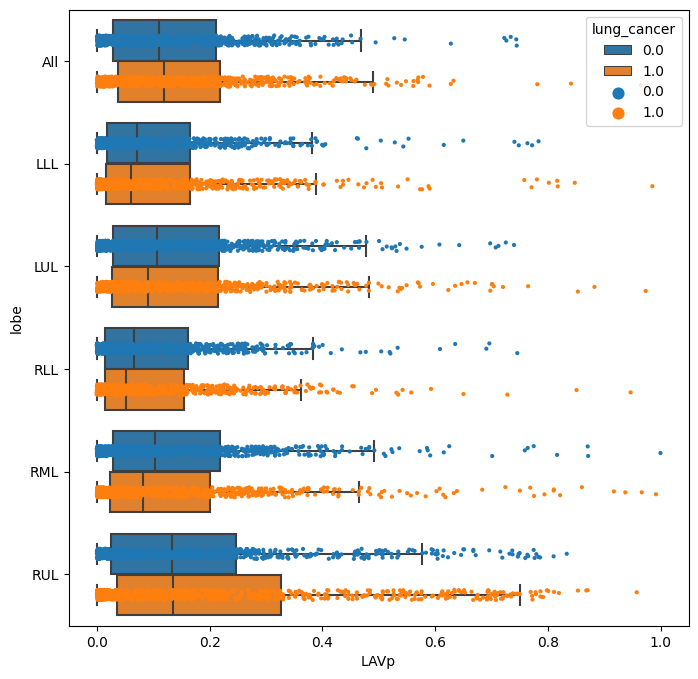

In [82]:
# visualize distributions of emphysema measures by lung cancer
cohort_grp = cohort_df.groupby('pid', as_index=False).max()
merged = cohort_grp.merge(emp, on='pid', how='inner')
merged['LAVp'] = merged['LAVp'].astype(float)

plt.figure(figsize=(8,8))
merged = merged[~((merged['lobe']=='Left') | (merged['lobe']=='Right'))]
sns.boxplot(x='LAVp', y='lobe', data = merged, hue='lung_cancer', showfliers=False, orient='h')
sns.stripplot(x='LAVp', y='lobe', data=merged, hue='lung_cancer', dodge=True, size=3, alpha=1, orient='h')
plt.show()

In [89]:
max_idx = emp.groupby('pid')['session'].transform(max) == emp['session']
max_emp = emp[max_idx]
max_emp['session'] = max_emp['session'].astype(str)

# max_emp

# long to wide
emp_ft = pd.pivot(max_emp, index=['pid', 'session'], columns='lobe', values=['lobe_vol', 'LAVp'])

# emp_ft = emp_ft[[['lobe_vol', 'All'], ['LAVp', 'All'], ['LAVp', 'LLL'], ['LAVp', 'LUL'], ['LAVp', 'RUL'], ['LAVp', 'RML'], ['LAVp', 'RLL']]]
# emp_ft.columns = ['vol_all', 'lavp_all', 'lavp_LLL', 'lavp_LUL', 'lavp_RUL', 'lavp_RML', 'lavp_RLL']
emp_ft = emp_ft.drop(columns=[('lobe_vol', 'Right'), ('lobe_vol', 'Left'), ('LAVp', 'Right'), ('LAVp', 'Left')])
emp_ft.columns = ['vol_all', 'vol_LLL', 'vol_LUL', 'vol_RLL', 'vol_RML', 'vol_RUL', 'lavp_all', 'lavp_LLL', 'lavp_LUL', 'lavp_RUL', 'lavp_RML', 'lavp_RLL']
emp_ft = emp_ft.reset_index()
emp_ft

,pid,session,vol_all,vol_LLL,vol_LUL,vol_RLL,vol_RML,vol_RUL,lavp_all,lavp_LLL,lavp_LUL,lavp_RUL,lavp_RML,lavp_RLL
0,100012,2000,5995.857006835938,1403.736950683594,1352.0076171875,1568.8380004882813,510.38835449218755,1160.886083984375,0.013415676269596034,0.012080607835542495,0.012688379072845807,0.0055211124120753035,0.03036965331670741,0.019092008911733852
1,100080,2001,5552.48828125,1303.21171875,1229.74296875,1470.70625,458.07265625,1090.7546875,0.0065710967141,0.004915740019699,0.01267541298963,0.002353248651796,0.009605463107142,0.006079506305124
2,100136,2001,2945.80700601339,669.47159832716,717.768720872998,700.142943604588,258.061468489766,600.362274718881,0.100781269444624,0.060642864965502,0.12449168669616,0.071922323346245,0.155798882300631,0.127199297543723
3,100138,2001,5164.71663818359,1159.37457275391,1178.88186035156,1400.58173828125,450.203051757813,975.675415039063,0.161054821187824,0.122568662503192,0.160141214816799,0.185896570809688,0.17142530684261,0.167445453263608
4,100147,2000,5063.293588152409,1022.3762280278206,1518.6009047763348,886.3551768393518,470.7292976932526,1165.2319808156492,0.028262814577673052,0.021979305707082095,0.037669150770295534,0.019589808003711975,0.016988192103358807,0.0326690606508678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,218391,2000,8380.383522033691,1827.3338470458984,2135.5747146606445,1705.1071014404297,924.4253540039062,1787.9425048828125,0.019935315545587688,0.014807527506457686,0.02197683904032984,0.010742045218142636,0.023868893226729415,0.029471173786810453
1441,218499,2001,8076.11921475017,1814.26632440746,2112.44193316042,1724.20410465896,677.547442743778,1747.65940977955,0.175495142428143,0.188116423520319,0.17899447800705,0.173713742272943,0.179909537003038,0.158209181217226
1442,218510,2001,8004.608799620569,1796.2184635546803,1974.7308432519435,1843.5069580325483,501.5432404288649,1888.6092943525314,0.1208294119119513,0.055899854447627406,0.12652914635592097,0.060683635863822624,0.13467993591442076,0.23165421253113533
1443,218750,2001,5641.21380892685,1394.4438240023,1303.04862216955,1241.99537455967,503.463819442719,1198.26216875261,0.178766337770922,0.03339224012113,0.043021378508484,0.02960905597604,0.01489335772813,0.719011270940999


In [90]:
cohort = cohort_df.groupby('pid', as_index=False).max()
cohort = cohort.merge(emp_ft, on='pid', how='inner')
cohort

,pid,id,session_x,age,race,education,bmi,copd,phist,fhist,...,vol_LUL,vol_RLL,vol_RML,vol_RUL,lavp_all,lavp_LLL,lavp_LUL,lavp_RUL,lavp_RML,lavp_RLL
0,100012,100012time2000,1,61.0,1.0,6.0,22.240116,0.0,False,False,...,1352.0076171875,1568.8380004882813,510.38835449218755,1160.886083984375,0.013415676269596034,0.012080607835542495,0.012688379072845807,0.0055211124120753035,0.03036965331670741,0.019092008911733852
1,100080,100080time2001,2,61.0,1.0,4.0,25.017398,0.0,False,True,...,1229.74296875,1470.70625,458.07265625,1090.7546875,0.0065710967141,0.004915740019699,0.01267541298963,0.002353248651796,0.009605463107142,0.006079506305124
2,100136,100136time2001,2,57.0,1.0,1.0,30.038373,0.0,False,False,...,717.768720872998,700.142943604588,258.061468489766,600.362274718881,0.100781269444624,0.060642864965502,0.12449168669616,0.071922323346245,0.155798882300631,0.127199297543723
3,100138,100138time2001,2,61.0,1.0,2.0,29.228138,0.0,False,False,...,1178.88186035156,1400.58173828125,450.203051757813,975.675415039063,0.161054821187824,0.122568662503192,0.160141214816799,0.185896570809688,0.17142530684261,0.167445453263608
4,100147,100147time2000,1,68.0,1.0,1.0,29.953440,0.0,True,True,...,1518.6009047763348,886.3551768393518,470.7292976932526,1165.2319808156492,0.028262814577673052,0.021979305707082095,0.037669150770295534,0.019589808003711975,0.016988192103358807,0.0326690606508678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,218391,218391time2000,1,66.0,1.0,6.0,23.674792,0.0,False,False,...,2135.5747146606445,1705.1071014404297,924.4253540039062,1787.9425048828125,0.019935315545587688,0.014807527506457686,0.02197683904032984,0.010742045218142636,0.023868893226729415,0.029471173786810453
1441,218499,218499time2001,2,63.0,1.0,2.0,23.110395,0.0,False,False,...,2112.44193316042,1724.20410465896,677.547442743778,1747.65940977955,0.175495142428143,0.188116423520319,0.17899447800705,0.173713742272943,0.179909537003038,0.158209181217226
1442,218510,218510time2001,2,64.0,1.0,6.0,27.802713,1.0,False,False,...,1974.7308432519435,1843.5069580325483,501.5432404288649,1888.6092943525314,0.1208294119119513,0.055899854447627406,0.12652914635592097,0.060683635863822624,0.13467993591442076,0.23165421253113533
1443,218750,218750time2001,2,55.0,1.0,5.0,19.485425,0.0,False,True,...,1303.04862216955,1241.99537455967,503.463819442719,1198.26216875261,0.178766337770922,0.03339224012113,0.043021378508484,0.02960905597604,0.01489335772813,0.719011270940999


In [91]:
cohort['lung_cancer'].value_counts()

0.0    724
1.0    721
Name: lung_cancer, dtype: int64

In [320]:
# features = [
#     'age', 'race', 'education',  'bmi',  'copd', 'phist', 'fhist', 'smo_status', 'quit_time', 'pkyr', 
#     'vol_all', 'vol_LLL', 'vol_LUL', 'vol_RLL', 'vol_RML', 'vol_RUL', 'lavp_all', 'lavp_LLL', 'lavp_LUL', 'lavp_RUL', 'lavp_RML', 'lavp_RLL'
# ]
features = [
    'age', 'race', 'education',  'bmi',  'copd', 'phist', 'fhist', 'smo_status', 'quit_time', 'pkyr', 
    'vol_all', 'lavp_all', 'lavp_LLL', 'lavp_LUL', 'lavp_RUL', 'lavp_RML', 'lavp_RLL'
]
cohort['lung_cancer'] = cohort['lung_cancer'].astype(int)
features_df = cohort[features]
x = pd.get_dummies(features_df, columns=['race', 'education'])
enc_features = x.columns
# Multiple linear imputation
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(x)
imp_x = pd.DataFrame(imp.transform(x), columns=enc_features)
imp_x[['bmi', 'copd', 'phist', 'fhist']] = imp_x[['bmi', 'copd', 'phist', 'fhist']].round()

# merge imputed values with cohort labels using an index join
cohort_enc = pd.merge(cohort.drop(columns=['bmi', 'copd', 'phist', 'fhist']), imp_x[['bmi', 'copd', 'phist', 'fhist']], left_index=True, right_index=True)

# # normalize by subtracting mean and dividing by std
# scalars = ['age', 'bmi', 'quit_time', 'pkyr', 'vol_all', 'vol_LLL', 'vol_LUL', 'vol_RLL', 'vol_RML', 'vol_RUL', 'lavp_all', 'lavp_LLL', 'lavp_LUL', 'lavp_RUL', 'lavp_RML', 'lavp_RLL']
scalars = ['age', 'bmi', 'quit_time', 'pkyr', 'vol_all', 'lavp_all', 'lavp_LLL', 'lavp_LUL', 'lavp_RUL', 'lavp_RML', 'lavp_RLL']
cohort_enc[scalars] = cohort_enc[scalars].astype(float)
cohort_enc[scalars].min()
cohort_enc[scalars] = (cohort_enc[scalars] - cohort_enc[scalars].min())/(cohort_enc[scalars].max() - cohort_enc[scalars].min())

In [327]:
import statsmodels.formula.api as smf
# formula_str = 'age+bmi+copd+phist+fhist+smo_status+quit_time+pkyr+vol_all+vol_LLL+vol_LUL+vol_RLL+vol_RML+vol_RUL+lavp_all+lavp_LLL+lavp_LUL+lavp_RUL+lavp_RML+lavp_RLL+C(race, Treatment(reference=1))+C(education, Treatment(reference=1))'
formula_str = 'age+bmi+copd+phist+fhist+smo_status+quit_time+pkyr+vol_all+lavp_LLL+lavp_LUL+lavp_RUL+lavp_RML+lavp_RLL+C(race, Treatment(reference=1))+C(education, Treatment(reference=1))'
smf_lr = smf.logit(f"lung_cancer ~ {formula_str}", data=cohort_enc).fit()
smf_lr.summary()

Optimization terminated successfully.
         Current function value: 0.634485
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            lung_cancer   No. Observations:                 1445
Model:                          Logit   Df Residuals:                     1418
Method:                           MLE   Df Model:                           26
Date:                Wed, 21 Sep 2022   Pseudo R-squ.:                 0.08463
Time:                        11:10:09   Log-Likelihood:                -916.83
converged:                       True   LL-Null:                       -1001.6
Covariance Type:            nonrobust   LLR p-value:                 5.142e-23
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -0.1237      0.365     -0.339      0.734      -0.838       0.591
C(race, Treatment(reference=1))[T.0.0]         -0.4416      0.619     -0.714      0.475      -1.654       0.771
C(race, Treatment(reference=1))[T.2.0]          0.2379      0.296      0.802      0.422      -0.343       0.819
C(race, Treatment(reference=1))[T.3.0]          0.3453      0.511      0.675      0.500      -0.657       1.348
C(race, Treatment(reference=1))[T.4.0]         -0.8313      0.443     -1.876      0.061      -1.700       0.037
C(race, Treatment(reference=1))[T.5.0]          0.1053      1.050      0.100      0.920      -1.952       2.163
C(race, Treatment(reference=1))[T.6.0]          0.0520      0.919      0.057      0.955      -1.750       1.854
C(education, Treatment(reference=1))[T.0.0]    -0.4220      0.438     -0.965      0.335      -1.280       0.436
C(education, Treatment(reference=1))[T.2.0]    -0.5976      0.248     -2.412      0.016      -1.083      -0.112
C(education, Treatment(reference=1))[T.3.0]    -0.6059      0.269     -2.254      0.024      -1.133      -0.079
C(education, Treatment(reference=1))[T.4.0]    -0.5027      0.251     -2.002      0.045      -0.995      -0.010
C(education, Treatment(reference=1))[T.5.0]    -0.6086      0.263     -2.314      0.021      -1.124      -0.093
C(education, Treatment(reference=1))[T.6.0]    -0.5906      0.278     -2.126      0.034      -1.135      -0.046
age                                             1.3719      0.218      6.301      0.000       0.945       1.799
bmi                                            -1.5658      0.614     -2.548      0.011      -2.770      -0.362
copd                                            0.6119      0.214      2.861      0.004       0.193       1.031
phist                                           0.2438      0.242      1.007      0.314      -0.231       0.718
fhist                                           0.2919      0.135      2.169      0.030       0.028       0.556
smo_status                                     -0.1197      0.168     -0.714      0.475      -0.448       0.209
quit_time                                      -0.8620      0.301     -2.866      0.004      -1.452      -0.272
pkyr                                            2.7221      0.532      5.119      0.000       1.680       3.764
vol_all                                         0.1843      0.495      0.372      0.710      -0.786       1.154
lavp_LLL                                        2.1766      1.122      1.940      0.052      -0.023       4.376
lavp_LUL                                       -0.1392      0.909     -0.153      0.878      -1.921       1.642
lavp_RUL                                       -3.5388      1.385     -2.554      0.011      -6.254      -0.823
lavp_RML                                        0.1402      0.672      0.209      0.835      -1.177      

In [326]:
odds = pd.DataFrame({"OR": smf_lr.params, "Lower CI": smf_lr.conf_int()[0], "Upper CI": smf_lr.conf_int()[1]})
odds = np.exp(odds)
odds["OR"] = odds["OR"].apply(lambda x: '{:.4f}'.format(x))
odds

,OR,Lower CI,Upper CI
Intercept,0.8836,0.432458,1.805512
"C(race, Treatment(reference=1))[T.0.0]",0.6430,0.191290,2.161523
"C(race, Treatment(reference=1))[T.2.0]",1.2686,0.709510,2.268320
"C(race, Treatment(reference=1))[T.3.0]",1.4124,0.518316,3.848665
"C(race, Treatment(reference=1))[T.4.0]",0.4355,0.182701,1.038056
"C(race, Treatment(reference=1))[T.5.0]",1.1110,0.141999,8.693207
"C(race, Treatment(reference=1))[T.6.0]",1.0533,0.173802,6.383862
"C(education, Treatment(reference=1))[T.0.0]",0.6557,0.278141,1.545842
"C(education, Treatment(reference=1))[T.2.0]",0.5501,0.338469,0.894072
"C(education, Treatment(reference=1))[T.3.0]",0.5456,0.322161,0.923894


In [323]:
import math
X, y = cohort_enc[features], cohort_enc['lung_cancer'].to_numpy().ravel()
y_prob = smf_lr.predict(cohort_enc[features])
y_hat = round(y_prob)

# accuracy_score
roc = roc_auc_score(y, y_prob)
report = classification_report(y, y_hat)
acc = accuracy_score(y, y_hat)
print(f"AUC: {roc}")
print(report)
print(f"Accuracy: {acc}")

AUC: 0.6920828192887412
              precision    recall  f1-score   support

           0       0.62      0.67      0.65       724
           1       0.64      0.60      0.62       721

    accuracy                           0.63      1445
   macro avg       0.63      0.63      0.63      1445
weighted avg       0.63      0.63      0.63      1445

Accuracy: 0.6318339100346021
